In [1]:
from citation_index.core.extractors import ExtractorFactory
import pandas as pd
import json
from Levenshtein import ratio as levenshtein_ratio

# Benchmarking results of EXCITE dataset

## 1. EXCITE dataset Overview

* Papers are divided into two groups (according to their language) and there are six different folders in each groups.
1. German_papers
   - There are 225 papers in this folder.
   - 219 paper with reference section at the end of document
   - 12 paper with references in footnote and at the end of document
   - 20 paper with references in footnote
2. English_papers
   - There are 100 papers in this folder.

In [ ]:

pdf_df = pd.read_csv("pdf_files_info.csv")
references_data = json.load(open("all_references.json", "r", encoding="utf-8"))


print('EXgoldstandard dataset:')
print(f"Total documents: {len(pdf_df)}")
print(f"Total pages: {pdf_df['page_count'].sum()}")
print(f"Total references: {sum(len(data['references']) for data in references_data.values())}")


Total documents: 351
Total pages: 8041
Total references: 10171


In [7]:
def get_sample_data(pdf_df, references_data, n_samples=5):
    """Display sample data for verification"""
    print(f"\n=== SAMPLE PDF DATA ===")
    if not pdf_df.empty:
        print(pdf_df.sample(n_samples).to_string(index=False))
    
    print(f"\n=== SAMPLE REFERENCES DATA ===")
    if references_data:
        sample_keys = list(references_data.keys())[:n_samples]
        for i, file_id in enumerate(sample_keys):
            ref_data = references_data[file_id]
            print(f"Paper {i+1} (ID: {file_id}):")
            print(f"  Number of references: {len(ref_data['references'])}")
            print(f"  First few references:")
            for j, ref in enumerate(ref_data['references'][:3]):
                print(f"    {j+1}. {ref}")
            if len(ref_data['references']) > 3:
                print(f"    ... and {len(ref_data['references']) - 3} more")
            print()
            
get_sample_data(pdf_df, references_data)


=== SAMPLE PDF DATA ===
 file_id  filename  class lang                                                                                                                       file_path  page_count
   28725 28725.pdf      1   en EXgoldstandard/Goldstandard_EXparser/2-English_papers/1-English_papers(with_reference_section_at_end_of_paper)/1-pdfs/28725.pdf          15
    6026  6026.pdf      1   de    EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/6026.pdf          11
    1630  1630.pdf      1   en  EXgoldstandard/Goldstandard_EXparser/2-English_papers/1-English_papers(with_reference_section_at_end_of_paper)/1-pdfs/1630.pdf          13
   19174 19174.pdf      1   de   EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/19174.pdf          10
   55362 55362.pdf      1   en EXgoldstandard/Goldstandard_EXparser/2-English_papers/1-English_papers(with_reference_sec

<Axes: ylabel='Frequency'>

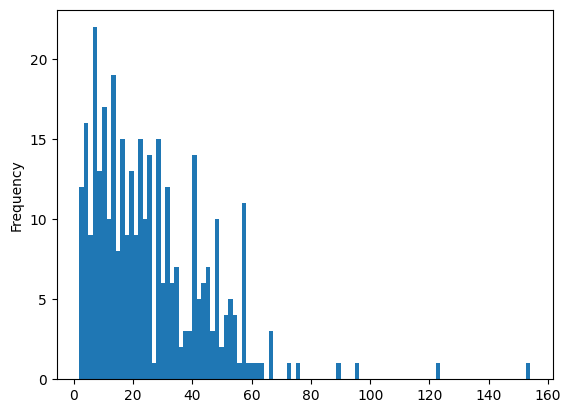

In [15]:
# add reference_count to pdf_df
pdf_df['reference_count'] = pdf_df['file_id'].map(lambda x: len(references_data[str(x)]['references']))
pdf_df['reference_count'].plot(kind='hist', bins=100)


<Axes: ylabel='Frequency'>

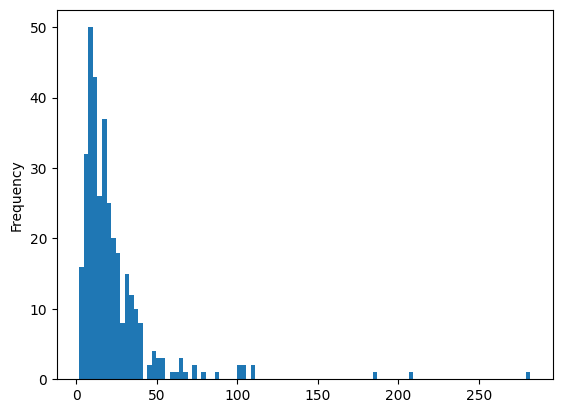

In [16]:
pdf_df['page_count'].plot(kind='hist', bins=100)

## 2. Benchmarking Results


### 2.1 Reference Extraction



In [1]:
%cd /Users/alex/docs/code/Odoma/citation_index

/Users/alex/docs/code/Odoma/citation_index


In [4]:
!python benchmarks/excite/run_excite_bench.py \
  --task extraction \
  --model_name mistralai/Mistral-Small-3.1-24B-Instruct-2503 \
  --api_key dummy_key \
  --responses_path benchmarks/excite/outputs/extraction_google_gemma_3_27b_it_pymupdf_20250718_094828_responses.pkl \
  --per_class   --skip_save

Results will be saved to: benchmarks/excite/outputs
Loaded 351 PDF records and 351 papers with references.
Loaded 0 LLM responses from benchmarks/excite/outputs/extraction_google_gemma_3_27b_it_pymupdf_20250718_094828_responses.pkl. Skipping LLM calls.
Evaluating 0 responses.
Evaluating responses: 0it [00:00, ?it/s]
Skipping saving results & metrics (--skip_save enabled).
LLM calls were skipped (responses loaded from file).


### 2.2 Reference Parsing


In [ ]:
!python benchmarks/excite/run_excite_bench.py \
  --task parsing \
  --model_name deepseek-ai/DeepSeek-Chat \
  --api_key dummy_key \
  --responses_path benchmarks/excite/outputs/parsing_deepseek_chat_pymupdf_20250718_001828_responses.pkl \
  --per_class   --skip_save

#### Benchmark Summary

```
{
  "precision": 0.8270206896551726,
  "recall": 0.7789028735632184,
  "micro_f1": 0.7816902298850574,
  "macro_f1": 0.7593508620689655
}
```

#### Focused field F1 scores

```
  authors: 0.7700
  full_title: 0.7552
  publication_date: 0.8468
```

####  Error statistics

```
  Parsing errors:   6
  Evaluation errors: 1
```

#### Per-class / language metrics

```
  class 1, lang de: precision: 0.8450, recall: 0.8296, micro_f1: 0.8262, macro_f1: 0.8121
  class 1, lang en: precision: 0.8088, recall: 0.7264, micro_f1: 0.7310, macro_f1: 0.7138
  class 2, lang de: precision: 0.7401, recall: 0.6578, micro_f1: 0.6878, macro_f1: 0.5929
  class 3, lang de: precision: 0.8083, recall: 0.4499, micro_f1: 0.5286, macro_f1: 0.4072
LLM calls were skipped (responses loaded from file).

In [ ]:
!python benchmarks/excite/run_excite_bench.py \
  --task parsing \
  --model_name google/gemma-3-27b-it \
  --api_key dummy_key \
  --responses_path benchmarks/excite/outputs/parsing_google_gemma_3_27b_it_pymupdf_20250718_013725_responses.pkl \
  --per_class   --skip_save

#### Benchmark Summary
```
{
  "precision": 0.8102494219653177,
  "recall": 0.8093760115606935,
  "micro_f1": 0.8053809248554913,
  "macro_f1": 0.7879118497109827
}
```

#### Focused field F1 scores
```
  authors: 0.7793
  full_title: 0.7693
  publication_date: 0.8993  
```

#### Error statistics
```
  Parsing errors:   0
  Evaluation errors: 1
```

#### Per-class / language metrics
```
  class 1, lang de: precision: 0.8353, recall: 0.8525, micro_f1: 0.8422, macro_f1: 0.8320
  class 1, lang en: precision: 0.7803, recall: 0.7815, micro_f1: 0.7775, macro_f1: 0.7652
  class 2, lang de: precision: 0.7312, recall: 0.6604, micro_f1: 0.6835, macro_f1: 0.6077
  class 3, lang de: precision: 0.7069, recall: 0.4636, micro_f1: 0.5356, macro_f1: 0.4421
LLM calls were skipped (responses loaded from file).

In [ ]:
!python benchmarks/excite/run_excite_bench.py \
  --task parsing \
  --model_name mistralai/Mistral-Small-3.1-24B-Instruct-2503 \
  --api_key dummy_key \
  --responses_path /Users/alex/docs/code/Odoma/citation_index/benchmarks/excite/outputs/parsing_mistralai_Mistral_Small_3.1_24B_Instruct_2503_pymupdf_20250718_094356_responses.pkl \
  --per_class   --skip_save

#### Benchmark Summary
```
{
  "precision": 0.7922778097982708,
  "recall": 0.7984573487031701,
  "micro_f1": 0.7927835734870317,
  "macro_f1": 0.7770432276657061
}
```

#### Focused field F1 scores
```
  authors: 0.7647
  full_title: 0.7699
  publication_date: 0.8689
```

#### Error statistics
```
  Parsing errors:   18
  Evaluation errors: 2
```

#### Per-class / language metrics
```
  class 1, lang de: precision: 0.8240, recall: 0.8392, micro_f1: 0.8299, macro_f1: 0.8190
  class 1, lang en: precision: 0.7557, recall: 0.7737, micro_f1: 0.7638, macro_f1: 0.7618
  class 2, lang de: precision: 0.6192, recall: 0.5870, micro_f1: 0.5999, macro_f1: 0.5213
  class 3, lang de: precision: 0.8157, recall: 0.5916, micro_f1: 0.6686, macro_f1: 0.5412
LLM calls were skipped (responses loaded from file).

### 2.3 Reference Extraction and Parsing

In [4]:
!python benchmarks/excite/run_excite_bench.py \
  --task extraction_and_parsing \
  --model_name mistralai/Mistral-Small-3.1-24B-Instruct-2503 \
  --api_key dummy_key \
  --responses_path benchmarks/excite/outputs/extraction_and_parsing_mistralai_Mistral_Small_3.1_24B_Instruct_2503_pymupdf_20250718_034619_responses.pkl \
  --per_class   --skip_save

Results will be saved to: benchmarks/excite/outputs
Loaded 351 PDF records and 351 papers with references.
Loaded 329 LLM responses from benchmarks/excite/outputs/extraction_and_parsing_mistralai_Mistral_Small_3.1_24B_Instruct_2503_pymupdf_20250718_034619_responses.pkl. Skipping LLM calls.
Evaluating 329 responses.
Evaluating responses: 100%|██████████████████| 329/329 [00:01<00:00, 224.10it/s]
Skipping saving results & metrics (--skip_save enabled).

--- Benchmark Summary ---
{
  "precision": 0.5076886850152905,
  "recall": 0.5387577981651376,
  "micro_f1": 0.5165131498470948,
  "macro_f1": 0.4965051987767584
}
-------------------------

Focused field F1 scores:
  authors: 0.4660
  full_title: 0.5111
  publication_date: 0.6046
-------------------------

Error statistics:
  Parsing errors:   96
  Evaluation errors: 0
Per-class / language metrics:
  class 1, lang de: precision: 0.4923, recall: 0.5404, micro_f1: 0.5096, macro_f1: 0.4893
  class 1, lang en: precision: 0.5625, recall: 0.59

In [ ]:
!python benchmarks/excite/run_excite_bench.py \
  --task extraction_and_parsing \
  --api_key dummy_key \
  --responses_path benchmarks/excite/outputs/extraction_and_parsing_google_gemma_3_27b_it_pymupdf_20250718_004905_responses.pkl \
  --per_class   --skip_save

Results will be saved to: benchmarks/excite/outputs
Loaded 351 PDF records and 351 papers with references.
Loaded 348 LLM responses from benchmarks/excite/outputs/extraction_and_parsing_google_gemma_3_27b_it_pymupdf_20250718_004905_responses.pkl. Skipping LLM calls.
Evaluating 348 responses.
Evaluating responses: 100%|██████████████████| 348/348 [00:01<00:00, 195.30it/s]
Skipping saving results & metrics (--skip_save enabled).

--- Benchmark Summary ---
{
  "precision": 0.6513606936416186,
  "recall": 0.5687196531791907,
  "micro_f1": 0.5862800578034683,
  "macro_f1": 0.5393300578034682
}
-------------------------

Error statistics:
  Parsing errors:   9
  Evaluation errors: 0
Per-class / language metrics:
  class 1, lang de: precision: 0.6567, recall: 0.5997, micro_f1: 0.6073, macro_f1: 0.5674
  class 1, lang en: precision: 0.6743, recall: 0.5952, micro_f1: 0.6185, macro_f1: 0.5769
  class 2, lang de: precision: 0.4041, recall: 0.2413, micro_f1: 0.2866, macro_f1: 0.1892
  class 3, lan